<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 100px">

# Capstone Project: Classifying Logistics Research Papers
## Part 7 : Final Model

---

 [Part 1: Get Text](01.Get_Text.ipynb) | [Part 2: Add Label](02.Add_Label.ipynb) | [Part 3: EDA](03.EDA.ipynb) | [Part 4: Gridsearch Classification](04.Gridsearch_Classification.ipynb) | [Part 5: Neural Network Classification](05.NeuralNet_Classification.ipynb) | [Part 6: Model Evaluation](06.Model_Evaluation.ipynb) | **Part 7: Final Model**

---

### Introduction
This notebook presents the final model for document classification based on extensive evaluation of different machine learning techniques. After thorough testing, the Neural Network model emerged as the best performing model.

The model leverages a **TF-IDF vectorizer** with the following optimal parameters:

- `max_df = 0.9` : To ignore terms that appear in more than 90% of the documents, reducing noise.
- `max_features = 5000` : To limit the number of features and focus on the most informative terms.

For tokenization, the `newmm` engine from `pythainlp` was used, which efficiently handles Thai text preprocessing.

The neural network model is designed with:

- **5 hidden layers** : To capture complex patterns in the data.
- **Activation function = Softmax** : For multi-class classification, ensuring that the output is a probability distribution across all classes.
- **Early stopping** : Implemented to prevent overfitting by halting training if the validation loss does not improve for a set number of epochs.

The final model was evaluated using various parameter configurations, and this approach proved to be the most effective for classifying the documents with the highest accuracy.

### Import Library

In [3]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import time

from pythainlp.tokenize import word_tokenize
from pythainlp.corpus.common import thai_words, thai_stopwords
from pythainlp.util import dict_trie

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.under_sampling import RandomUnderSampler
from tabulate import tabulate

from tensorflow.keras.models import Sequential, save_model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping 
import joblib


In [4]:
df = pd.read_csv('../data/cleaned_text.csv')
df.head()

,Unnamed: 0,project,abstract,content,category,category_id,content_length,abstract_length,content_word_count,abstract_word_count
0,0,การจัดทำคู่มือขั้นตอนการดำเนินการการนำเข้าคราฟ...,ผู้วิจัยได้ตระหนักถึงความยุ่งยากของขั้นตอนการน...,การจัดทำคู่มือขั้นตอนการดำเนินการการนำเข้าคราฟ...,Import-Export,5,11582,860,2402,171
1,1,การเสนอแนวทางในการพัฒนาและสร้างความสัมพันธ์กับ...,งานวิจัยครั้งนี้มีวัตถุประสงค์เพื่อเสนอแนวทางใ...,การเสนอแนวทางในการพัฒนาและสร้างความสัมพันธ์กับ...,Procurement and Sourcing,0,15230,1186,3601,267
2,2,การพัฒนามาตรฐานรถขนส่งวัตถุอันตรายที่เข้ามาในค...,ดำเนินธุรกิจเป็นผู้นำเข้า และจัดจำหน่ายสินค้าก...,การพัฒนามาตรฐานรถขนส่งวัตถุอันตรายที่เข้ามาในค...,Distribution and Transportation,3,13587,1964,2883,383
3,3,แนวทางการปรับปรุงกระบวนการการส่งเอกสารใบกำกับภ...,การวิจัยครั้งนี้มีวัตถุประสงค์ เพื่อศึกษาขั้นต...,แนวทางการปรับปรุงกระบวนการการส่งเอกสารใบกำกับภ...,Procurement and Sourcing,0,13124,1260,3283,269
4,4,การศึกษาเทคนิคการพยากรณ์ยอดขายสายไฟที่เหมาะสม,จากสถานการณ์การแพร่ระบาดของเชื้อไวรัสโคโรนา 20...,การศึกษาเทคนิคการพยากรณ์ยอดขายสายไฟที่เหมาะสม ...,Demand Planning,4,25247,1956,6114,496


In [28]:
# Add custom word to keep from 5 sample abstract
added_words = ['การนำเข้า', 'ฐานนิยม', 'คราฟท์', 'แนวทาง', 'ผู้ส่งมอบ', 'โซ่อุปทาน', 'ปัจจัยรอง', 
               'การส่งมอบ', 'รถขนส่ง', 'นำไปใช้งาน', 'อย่างถูกต้อง', 'การขับรถ', 'ที่เกี่ยวข้อง', 
               'ในการปฏิบัติงาน', 'พนักงานขับรถ', 'สิ่งสำคัญ', 'ขั้นตอน', 'ที่ชัดเจน', 'การไหล', 'ยอดขาย', 
              'การจัดทำ', 'คราฟท์เบียร์', 'ฝึกสหกิจ', 'อย่างก้าวกระโดด','การจัดซื้อจัดหา','กระบวนการ',
               'แบบประเมิน','เก็บข้อมูล','อย่างชัดเจน','การดำเนินการ','การส่งเสริม','ถังดับเพลิง','แนวทาง']

# Merge custom words with Thai dictionary words
custom_words = set(thai_words()).union(added_words)
custom_trie = dict_trie(custom_words)  # Create a trie from the custom dictionary

In [29]:
def thai_preprocess(text):
    tokens = word_tokenize(text, custom_dict= custom_trie, engine="newmm")
    return " ".join([token for token in tokens if token not in thai_stopwords()])

In [5]:
# Create fuction to fit Neural Network model
def nn_model(X_train_tfidf, X_test_tfidf, y_train_encoded, y_test_encoded):
    
    # Early stop
    es = EarlyStopping(
        monitor = 'val_loss'
        , patience = 5
        , restore_best_weights = True 
    )
    
    model = Sequential()
    model.add(Input(shape=(5000,)))
    model.add(BatchNormalization())

    model.add(Dense(512, activation='relu')) # 512 neurons with ReLU activation
    model.add(Dropout(0.2)) #  Dropout layers (with a rate of 0.2)

    model.add(Dense(256, activation='relu')) # 256 neurons with ReLU activation
    model.add(Dropout(0.2)) #  Dropout layers (with a rate of 0.2)

    model.add(Dense(128, activation='relu')) # 128 neurons with ReLU activation
    model.add(Dropout(0.2)) #  Dropout layers (with a rate of 0.2)

    model.add(Dense(64, activation='relu')) # 64 neurons with ReLU activation
    model.add(Dense(32, activation='relu')) # 32 neurons with ReLU activation
    
    model.add(Dense(len(df['category'].unique()), activation='softmax'))  # Softmax for multi-class classification / 8 classes
    
    # model compile
    model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    # train model
    model.fit(X_train_tfidf, y_train_encoded, epochs=50, batch_size=4, validation_data=(X_test_tfidf, y_test_encoded), callbacks = [es], verbose =0)
    
    # predict
    y_pred_nn = model.predict(X_test_tfidf, verbose =0)
    y_pred_nn = y_pred_nn.argmax(axis=1)  # transform predict value to class
    
    # transform y back to value
    y_pred_nn = label_encoder.inverse_transform(y_pred_nn)
    
    return accuracy_score(y_test, y_pred_nn),y_pred_nn,model

In [6]:
X = df['content'].apply(thai_preprocess)
y = df['category']

In [7]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Apply TF-IDF
tfidf = TfidfVectorizer(max_features=5000, max_df=0.9)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# transform y_train and y_test to numeric
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

In [ ]:
score, y_pred, model =  nn_model(X_train_tfidf, X_test_tfidf, y_train_encoded, y_test_encoded)

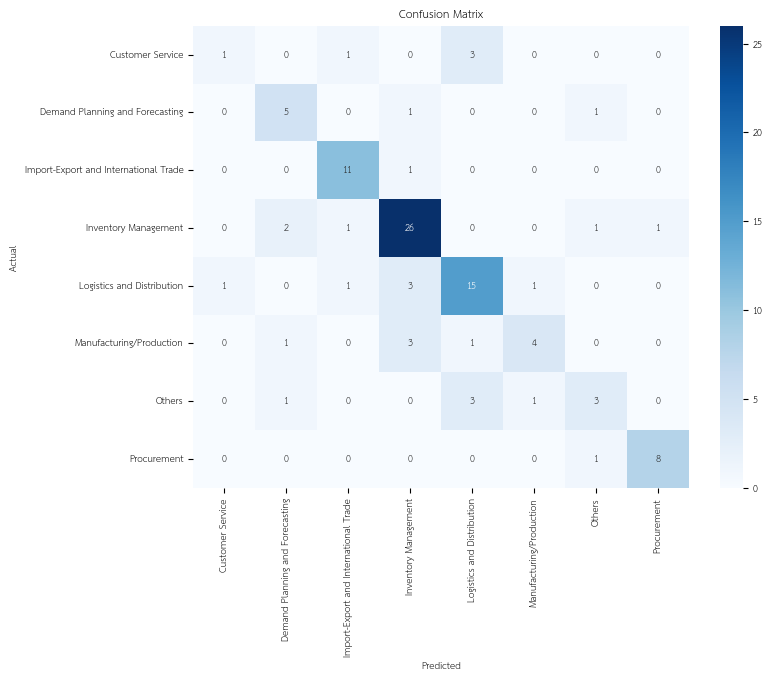

In [16]:
# Set a font that supports Thai characters.
matplotlib.rcParams['font.family'] = 'TH SarabunPSK'

# create confusion matrix
cm = confusion_matrix(y_test, y_pred)

# create heatmap for confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

plt.savefig('../images/confusion_matrix.png', dpi = 300, bbox_inches = 'tight')

plt.show()

In [117]:
# Generate the classification report as a string
report_dict = classification_report(y_test, y_pred, target_names=label_encoder.classes_,output_dict=True)

# Prepare the table data from the dictionary
table_data = []
for category, metrics in report_dict.items():
    if category not in ['accuracy', 'macro avg', 'weighted avg']:  # Exclude the summary lines
        table_data.append([category, round(metrics['precision'],2), round(metrics['recall'],2), round(metrics['f1-score'],2), round(metrics['support'])])

# Add column headers for the table
headers = ["Category", "Precision", "Recall", "F1-Score", "Support"]

print(f'Accuracy score: {score:.4f}\n')
# Display the report using tabulate for a nicer table format
print(tabulate(table_data, headers=headers, tablefmt='pretty'))


Accuracy score: 0.7157

+---------------------------------------+-----------+--------+----------+---------+
|               Category                | Precision | Recall | F1-Score | Support |
+---------------------------------------+-----------+--------+----------+---------+
|           Customer Service            |    0.5    |  0.2   |   0.29   |    5    |
|    Demand Planning and Forecasting    |   0.56    |  0.71  |   0.62   |    7    |
| Import-Export and International Trade |   0.79    |  0.92  |   0.85   |   12    |
|         Inventory Management          |   0.76    |  0.84  |   0.8    |   31    |
|      Logistics and Distribution       |   0.68    |  0.71  |   0.7    |   21    |
|       Manufacturing/Production        |   0.67    |  0.44  |   0.53   |    9    |
|                Others                 |    0.5    |  0.38  |   0.43   |    8    |
|              Procurement              |   0.89    |  0.89  |   0.89   |    9    |
+---------------------------------------+-----------

**The model performs well** in `Procurement`, `Import-Export`,  `Inventory Management` and `Logistics and Distribution` categories. 

**Struggles** in  `Manufacturing/Production`, `Others`, `Customer Service` and  due to low F1-scores.

### Save model and Testing

In [120]:
# Save the model, tfidf, and label encoder together in a dictionary
saved_objects = {
    'tfidf': tfidf,
    'model': model,
    'label_encoder': label_encoder
}

# Save the combined dictionary to a single file
joblib.dump(saved_objects, '../model/model.pkl')

['../model/model.pkl']

In [10]:
# Load the dictionary from the file
objects = joblib.load('../model/model.pkl')

# Access individual components
tfidf = objects['tfidf']
model = objects['model']
label_encoder = objects['label_encoder']

In [126]:
text = """งานวิจัยนี้มีวัตถุประสงค์เพื่อ เพื่อศึกษาสภาพปัจจุบันและปัญหาที่เกี่ยวข้องกับการจัดการพัสดุคงคลังของส่วนราชการ, 
เพื่อทำการจัดลำดับการเข้าก่อนออกก่อนของพัสดุคงคลังในแต่ละงวดการรับพัสดุ และเพื่อเปรียบเทียบความรวดเร็ว 
ความถูกต้องแม่นยำของข้อมูลพัสดุคงคลังกับทะเบียนคุม โดยการนำแนวทางการจัดการพัสดุคงคลังที่เหมาะสมมาประยุกต์ใช้ 
เพื่อให้การปรับปรุงมีประสิทธิภาพ ประชากรที่ใช้ในการวิจัยครั้งนี้คือ พัสดุคงคลังประเภทวัสดุสานักงานและคอมพิวเตอร์ 
ซึ่งได้มาจากการทบทวนเอกสารการสั่งซื้อวัสดุครุภัณฑ์ประจาปี 2558 – 2561 เป็นตัวแทนของประชากรทั้งหมดเพื่อนำมาทำการวิจัย ผลการศึกษาวิจัยสภาพปัญหาที่เกิดขึ้น
ประกอบกับลักษณะขององค์การ พบว่าปัญหา ที่เกิดขึ้นในองค์การที่สำคัญ คือ ปัญหาด้านการจัดการพัสดุคงคลังมีพัสดุไม่สามารถตรวจสอบปริมาณพัสดุทั้งหมดที่แท้จริงได้ 
และการหยิบพัสดุจากพื้นที่จัดเก็บหาพัสดุไม่พบ เนื่องจาก การจัดเก็บไม่เป็นระเบียบ ไม่มีหลักเกณฑ์ การประเมินประสิทธิภาพระบบการจัดการพัสดุคงคลังก่อนและหลังการประยุกต์ใช้เทคนิค
การควบคุม จากผลการเปรียบเทียบความเร็วของการหยิบ ตั้งแต่เดือน พ.ค. 2561 – ส.ค. 2561 พบว่าโดยหลังการปรับปรุงเวลาการหยิบ (นาที) ของแต่ละรายการลดลงอย่างเห็นได้ชัด 
เมื่อเรียงลำดับจากมากไปหาน้อยของแต่ละรายการโดยลำดับแรกคือ ปากกาลูกลื่น สีน้าเงิน เวลา การหยิบเดือน พ.ค. คือ 14.43 นาที และเดือนสุดท้ายที่ทำการทดลองคือเดือน ส.ค. 
เท่ากับ 2.15 นาที ลดลง 12.28 นาที และลำดับสุดท้ายคือ หมึกเครื่องถ่ายแอกสาร Kyocera เวลาการหยิบเดือน พ.ค. คือ 13.10 นาที และเดือนสุดท้ายที่ทำการทดลองคือ
เดือน ส.ค. เท่ากับ 1.43 นาที ลดลง 11.67 นาที แสดงถึงความมีประสิทธิภาพที่ดีขึ้นจากเดิม และจากผลการเปรียบเทียบความถูกต้องของข้อมูลพัสดุคงคลังที่มีอยู่จริงกับทะเทียนคุม
ในปี 2558 – 2561 ของรายการลวดเสียบกระดาษ พบว่าการนำเทคนิค Visual Control และ FIFO มีผลความผิดพลาดของข้อมูลสูงที่ 100% หมายความว่ายังไม่มีประสิทธิภาพในการจัดการพอสมควร"""


# Use the model for prediction
text_tfidf = tfidf.transform([text])  # Transform your input text
prediction = model.predict(text_tfidf.toarray(), verbose = 0)  # Convert sparse matrix to dense array
# Decode class labels
all_classes = label_encoder.inverse_transform(range(prediction.shape[1]))

# Combine classes and probabilities into a list of tuples
class_probs = list(zip(all_classes, prediction[0]))

# Sort class_probs by the second element (probability) in descending order
sorted_class_probs = sorted(class_probs, key=lambda x: x[1], reverse=True)
for cat in sorted_class_probs:
    print(f"Class: {cat[0]}")
    print(f'Probability :{cat[1]*100:.2f}%\n')

Class: Inventory Management
Probability :21.76%

Class: Manufacturing/Production
Probability :19.67%

Class: Logistics and Distribution
Probability :13.30%

Class: Demand Planning and Forecasting
Probability :12.62%

Class: Procurement
Probability :10.46%

Class: Others
Probability :9.05%

Class: Customer Service
Probability :8.31%

Class: Import-Export and International Trade
Probability :4.83%

